In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from tqdm import tqdm 

In [2]:
p_e=50 #equilibrium price

#boundries for the price
p_max=100
p_min=0.1

#
H=5 #half-life of the price process
lam=np.log10(2)/H #decay rate of the price process
sigma=0.1 
tick_size=0.1 #tick size
alpha=0.001 #step size parameter
gamma=0.999 #discount rate
kappa=0.0001 #risk aversion parameter
epsilon=0.1 #greedy parameter

In [3]:
lot_size=100
max_trade_size=5
max_position_size=10

#action space 
action_space=[lot_size*i for i in range(-max_trade_size,max_trade_size+1)]
print(action_space)

#holding space
holding_space=[lot_size*i for i in range(-max_position_size,max_position_size+1)]
print(holding_space)

#price space
price_space=[round(p_min+tick_size*i,1) for i in range(int((p_max-p_min)/tick_size)+1)]
print(price_space)

[-500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500]
[-1000, -900, -800, -700, -600, -500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4,

In [4]:

#function to generate price list using Ornstein-Uhlenbeck process
def generate_price(n,p_e,lam,sigma):
    p_list=[]
    #select initial price randomly from price_space
    p_i=price_space[np.random.randint(0,len(price_space))]

    for i in tqdm(range(n)):
        #add standard descretisation of Ornstein-Uhlenbeck process
        x_t=np.log10(p_i/p_e)
        d_x_t=-lam*x_t+sigma*np.random.normal(0,1)

        x_t=x_t+d_x_t
        p_i=p_e*np.exp(x_t)
        p_i=round(p_i,1)

        #APPLYING BOUNDRIES
        p_i=max(p_min,min(p_i,p_max))
        p_list.append(p_i)
        
    return p_list

n=2*(10**7)
p_list=generate_price(n,p_e,lam,sigma)

100%|██████████| 20000000/20000000 [05:27<00:00, 61085.94it/s]


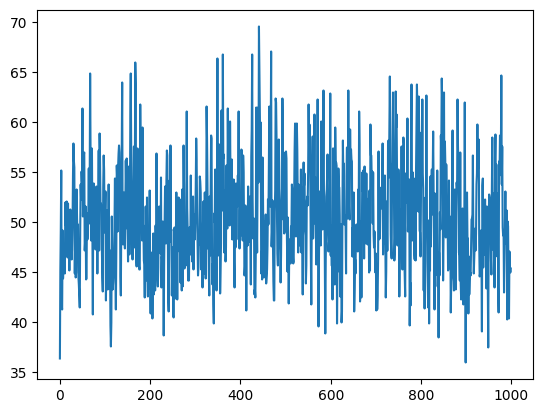

Mean of price: 50.29982899500005
Standard deviation of price: 5.525356305185876


In [5]:
#plotting the price
plt.plot(p_list[:1000])
plt.show()

#print average price
print("Mean of price:",np.mean(p_list))
#print standard deviation of price
print("Standard deviation of price:",np.std(p_list))


In [6]:
#spread cost
def spread_cost(delta_n):
    return tick_size*abs(delta_n)

#impact cost
def impact_cost(delta_n):
    return (delta_n**2)*tick_size/lot_size

#total cost
def total_cost(delta_n):
    return spread_cost(delta_n)+impact_cost(delta_n)

#function to select action
def select_action(state,q_table):

    n_current=state[0]
    price=state[1]

    prob=np.random.uniform(0,1)

    if prob<=epsilon:
        action=np.random.choice(action_space)
    
    else:
        #select the q values for the current state
        q_values=q_table[price_space.index(price),holding_space.index(n_current)]

        #select the set of best actions
        max_q_values=np.max(q_values)
        max_q_index=np.where(q_values==max_q_values)[0]

        #select a random action among the best actions
        action=action_space[np.random.choice(max_q_index)]
    
    #check if the action is feasible
    if n_current+action>max_position_size*lot_size:
        action=max_position_size*lot_size-n_current
    elif n_current+action<-max_position_size*lot_size:
        action=-max_position_size*lot_size-n_current

    return action

#calculate the reward
def reward(delta_n,n_t,p_current,p_next):
    
    #compute the change in portfolio value as delta_v
    delta_v=n_t*(p_next-p_current)-total_cost(delta_n)

    #compute the reward as 
    reward=delta_v-0.5*kappa*(delta_v**2)

    return reward

In [7]:
#load if Q-table exists
# if os.path.exists('Q_table.npy'):
#     Q=np.load('Q_table.npy')
# else:
Q = np.zeros((len(price_space), len(holding_space), len(action_space)))

#dimensions of the Q-table
print(Q.shape)

(1000, 21, 11)


In [8]:
#iterate over the p_list to train the Q-table
state=[]
#select random price and holding
initial_price=np.random.choice(price_space)
initial_n=np.random.choice(holding_space)
state=[initial_n,initial_price]
for i in tqdm(range(0, len(p_list) - 1), desc="Processing"):
    
    # print(i)
    p_current=p_list[i]
    p_next=p_list[i+1]
    n_prev=state[0]
    p_prev=state[1]
    state=[n_prev,p_current]

    #select action
    delta_n=select_action(state,Q)

    n_current=n_prev+delta_n

    #calculate reward
    r=reward(delta_n,n_current,p_current,p_next)

    #update Q-table
    holding_index=holding_space.index(n_prev)
    price_index=price_space.index(p_current)
    action_index=action_space.index(delta_n)

    
    new_holding_index=holding_space.index(n_current)
    next_price_index=price_space.index(p_next)
    
    Q[price_index,holding_index,action_index]=Q[price_index,holding_index,action_index]+alpha*(r+gamma*np.max(Q[next_price_index,new_holding_index,:])-Q[price_index,holding_index,action_index])

    #update state
    state=[n_current,p_current]


Processing: 100%|██████████| 19999999/19999999 [44:37<00:00, 7469.76it/s] 


In [13]:
print(Q)
# SAVE THE Q-TABLE
np.save('Q_table.npy',Q)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [14]:
test_size=5000
p_list_eval=generate_price(test_size,p_e,lam,sigma)

100%|██████████| 5000/5000 [00:00<00:00, 63082.11it/s]


In [15]:
#since q_table is already loaded check the performance of the agent
TOTAL_PNL=0
CMT_PNL=[]
#select random price and holding
initial_price=np.random.choice(price_space)
initial_n=np.random.choice(holding_space)
state=[initial_n,initial_price]

for i in range(0,len(p_list_eval)-1):
    p_current=p_list_eval[i]
    # p_next=p_list_eval[i+1]
    n_prev=state[0]
    p_prev=state[1]
    state=[n_prev,p_current]

    #select action
    delta_n=select_action(state,Q)

    wealth_change=n_prev*(p_current-p_prev)-total_cost(delta_n)
    n_current=n_prev+delta_n

    #CALUCULATE THE CUMULATIVE REWARD
    TOTAL_PNL+=wealth_change
    row={'step':i,'reward':wealth_change,'total_reward':TOTAL_PNL}
    CMT_PNL.append(row)

    n_prev=n_current
    #update state
    state=[n_prev,p_current]

In [16]:
CMT_REWARD=pd.DataFrame(CMT_PNL)
fig=px.line(CMT_REWARD,x='step',y='total_reward',title='Cumulative simulated out-of-sample P&L of trained model (over 5,000 periods)')
#update the x-axis and y-axis labels
fig.update_xaxes(title_text='Time Periods')
fig.update_yaxes(title_text='Cumulative P&L(in $)')
fig.show()